# Airline Sentiment Analysis

In [44]:
# data wrangling
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# stats
from sklearn.metrics import f1_score, accuracy_score

# classifiers
from sklearn.svm import LinearSVC

# NLP
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# pytorch framework
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch.nn.utils.rnn import pad_sequence

# pytorch-lightning framework
import pytorch_lightning as pl

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import shutil
import os

# Data Wrangling

In [3]:
tweets_df = pd.read_csv('../data/Tweets.csv')[['tweet_id', 'airline', 'airline_sentiment', 'text']]
print(tweets_df.shape)
tweets_df.head(3)

(14640, 4)


,tweet_id,airline,airline_sentiment,text
0,570306133677760513,Virgin America,neutral,@VirginAmerica What @dhepburn said.
1,570301130888122368,Virgin America,positive,@VirginAmerica plus you've added commercials t...
2,570301083672813571,Virgin America,neutral,@VirginAmerica I didn't today... Must mean I n...


# Exploratory Data Analysis

<AxesSubplot:>

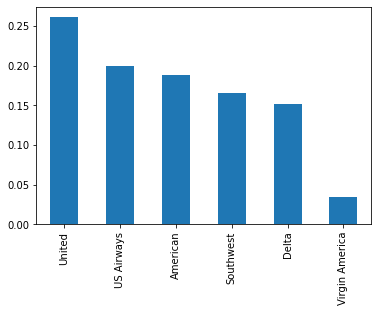

In [4]:
tweets_df['airline'].value_counts(normalize=True).plot(kind='bar')

<AxesSubplot:xlabel='airline', ylabel='prop'>

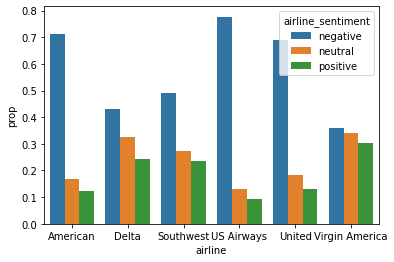

In [5]:
aux = (
    tweets_df.groupby(
        ['airline', 'airline_sentiment']
    ).size() /
    tweets_df.groupby(
        ['airline']
    ).size()
).reset_index(name='prop') 

sns.barplot(
    data=aux,
    y='prop',
    x='airline',
    hue='airline_sentiment'
)

# Modelling

In [6]:
def calculate_key_metrics(y_test, y_pred):
    ac = accuracy_score(y_test, y_pred)
    fs = f1_score(y_test, y_pred, average='weighted')

    return pd.Series([ac, fs], index=['accuracy_score', 'f1_score'])

In [7]:
le = LabelEncoder()
y = le.fit_transform(tweets_df['airline_sentiment'].values)
print(list(enumerate(le.classes_)))

[(0, 'negative'), (1, 'neutral'), (2, 'positive')]


### TF-IDF + SVM

In [8]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    analyzer='word',
    ngram_range=(1,2)
)
X = vectorizer.fit_transform(tweets_df['text'].tolist())

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)

In [10]:
svc = LinearSVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

calculate_key_metrics(y_test, y_pred)

accuracy_score    0.771107
f1_score          0.751608
dtype: float64

## miniLM (BERT-based Transformer) + Classifier

In [12]:
sentence_model = SentenceTransformer('all-MiniLM-L12-v2')
embeddings = sentence_model.encode(
    tweets_df['text'].tolist(),
    show_progress_bar=True
)
embeddings

Batches:   0%|          | 0/458 [00:00<?, ?it/s]

array([[ 0.00308908,  0.0864738 , -0.04533323, ..., -0.06762805,
        -0.00764817, -0.02906492],
       [-0.017044  ,  0.04139121,  0.053099  , ..., -0.07246979,
         0.00061237, -0.03143206],
       [ 0.01765138, -0.00182619,  0.05536727, ..., -0.08177376,
        -0.11430355, -0.04604586],
       ...,
       [-0.03829892,  0.04668225,  0.00996541, ..., -0.00989373,
        -0.0421861 , -0.03488282],
       [ 0.04306993,  0.04515231,  0.01435219, ..., -0.04968503,
        -0.07981985, -0.04574215],
       [ 0.02641935,  0.01136149, -0.06087457, ...,  0.06373028,
        -0.08687644,  0.02736992]], dtype=float32)

In [ ]:
# disable boring warnings from the sentence_transformers library
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### SVM

In [13]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=1/3)

In [14]:
svc = LinearSVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

calculate_key_metrics(y_test, y_pred)

accuracy_score    0.829918
f1_score          0.825445
dtype: float64

### Neural Networks (Linear Layer)

In [37]:
class EmbeddingArray(Dataset):
    """Our Pytorch Dataset for our embeddings.
    """
    def __init__(self, embeddings:np.ndarray, y:np.ndarray=None, transform=None):
        
        self.embeddings = embeddings
        self.transform = transform
        self.y = y

    def __len__(self):
        return self.embeddings.shape[0]
    
    def __getitem__(self, idx):
        label = self.y[idx] if isinstance(self.y, np.ndarray) else None
        features = self.embeddings[idx]
            
        sample = {'label': label, 'features': features}
        
        if self.transform:
            sample = self.transform(sample)

        return sample


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        label, features = sample['label'], sample['features']

        # If data is to be predicted.
        if not isinstance(label, np.ndarray):
            sample = {
                'label': label,
                'features': torch.from_numpy(features).type(torch.FloatTensor)
            }
        else:
            sample = {
                'label': torch.from_numpy(np.array(label)).type(torch.LongTensor),
                'features': torch.from_numpy(features).type(torch.FloatTensor)
            }
        
        return sample

for sample in EmbeddingArray(embeddings=embeddings, transform=ToTensor()):
    print(sample['label'], sample['features'].shape)
    break

None torch.Size([384])


In [38]:
# 10% test, 9% validation, 81% train
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=1/10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/10)

dataset_dict = {
    'train': EmbeddingArray(embeddings=X_train,y=y_train,transform=ToTensor()),
    'test': EmbeddingArray(embeddings=X_test,y=y_test,transform=ToTensor()),
    'val': EmbeddingArray(embeddings=X_val,y=y_val,transform=ToTensor())
}

After we have trained the model we can inspectionate the model performance via the shell command:

"tensorboard --logdir=lightning_logs/ --host=0.0.0.0".

The tensoboard package is more complete than any plots that we could make.

In [69]:
class LinearClassifier(pl.LightningModule):
    def __init__(self,dataset_dict):
        super().__init__()

        self.dataset_dict = dataset_dict
        self.fc = nn.Linear(384, 3) # embedding dim -> sentiments (neg, neut, pos)

        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch['features'], batch['label']
        y_hat = self(x)

        loss = self.criterion(y_hat, y)
        
        self.log("train_loss", loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch['features'], batch['label']
        y_hat = self(x)

        loss = self.criterion(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    
    def train_dataloader(self):
        return DataLoader(
            self.dataset_dict['train'],
            batch_size=100,
            num_workers=2,
            shuffle=True
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.dataset_dict['val'],
            batch_size=100,
            num_workers=2,
            shuffle=False
        )

model = LinearClassifier(
    dataset_dict=dataset_dict
)


# deleting previous model logs
shutil.rmtree('../lightning_logs', ignore_errors=True)

trainer = pl.Trainer(
    default_root_dir='../',
    #log_every_n_steps=5,
    max_epochs=20,
    enable_progress_bar=False
)

trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../lightning_logs

  | Name      | Type             | Params
-----------------------------------------------
0 | fc        | Linear           | 1.2 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
/home/adriel-martins/.cache/pypoetry/virtualenvs/airline-sentiment-2PQ9Xza8-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [70]:
@torch.no_grad()
def predict_class(model, test_dataloader):
    for index, sample in enumerate(test_dataloader):
        features, label = sample['features'], sample['label']
        y_hat = model(features)
        preds = nn.functional.softmax(y_hat, dim=1)
        y_hat = torch.argmax(preds, dim=1)

        if index == 0:
            final_tensor = y_hat
        else:
            final_tensor = torch.cat((final_tensor, y_hat))
    return final_tensor

y_pred = predict_class(
    model,
    test_dataloader=DataLoader(
        dataset_dict['test'],
        batch_size=100,
        num_workers=2,
        shuffle=False
    )
).numpy()

calculate_key_metrics(y_test, y_pred)

accuracy_score    0.793033
f1_score          0.781258
dtype: float64